<a href="https://colab.research.google.com/github/pradyumna4998/Intro-to-ML/blob/main/HW7_Q2_Intro_to_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Introduction to Machine Learning

                                            Homework 7

Question 2

Name : V.pradyumna

Student ID : 801345963

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00
time: 249 µs (started: 2023-12-13 19:10:16 +00:00)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

time: 6.84 s (started: 2023-12-13 19:10:19 +00:00)


In [ ]:
 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 51 ms (started: 2023-12-13 19:10:28 +00:00)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

time: 380 µs (started: 2023-12-13 19:10:30 +00:00)


In [ ]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:03<00:00, 43996002.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 16.2 s (started: 2023-12-13 19:10:32 +00:00)


In [ ]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 27.5 ms (started: 2023-12-13 19:10:50 +00:00)


In [ ]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.31 ms (started: 2023-12-13 19:10:51 +00:00)


In [ ]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 449 ms (started: 2023-12-13 19:10:54 +00:00)


In [ ]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 351 ms (started: 2023-12-13 19:10:56 +00:00)


In [ ]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

time: 684 µs (started: 2023-12-13 19:10:59 +00:00)


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 401 µs (started: 2023-12-13 19:11:01 +00:00)


In [ ]:
print(torch.__version__)

2.1.0+cu118
time: 384 µs (started: 2023-12-13 19:11:02 +00:00)


In [ ]:

import datetime
def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                training_loss / len(training_loader)))



time: 782 µs (started: 2023-12-13 19:11:06 +00:00)


In [ ]:
class Residual_Block(nn.Module):
    def __init__(self, n_chans):
        super(Residual_Block, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

time: 701 µs (started: 2023-12-13 19:11:09 +00:00)


In [ ]:

import torch.nn.functional as F
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [Residual_Block(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.11 ms (started: 2023-12-13 19:11:12 +00:00)


In [ ]:
device

device(type='cuda')

time: 2.52 ms (started: 2023-12-13 19:11:14 +00:00)


In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_function = loss_fn,
    training_loader = training_loader,
)

2023-12-13 20:03:00.527147 Epoch 1, Training loss 1.6118848965630193
2023-12-13 20:03:21.050191 Epoch 2, Training loss 1.2846244199109702
2023-12-13 20:04:03.648656 Epoch 4, Training loss 1.059674482771165
2023-12-13 20:04:46.101001 Epoch 6, Training loss 0.9452411311983071
2023-12-13 20:05:28.879604 Epoch 8, Training loss 0.8621432640311509
2023-12-13 20:06:11.091502 Epoch 10, Training loss 0.8085875278165991
2023-12-13 20:06:53.656672 Epoch 12, Training loss 0.7597493455719658
2023-12-13 20:07:36.407933 Epoch 14, Training loss 0.7197974290095761
2023-12-13 20:08:18.564753 Epoch 16, Training loss 0.6879466679221304
2023-12-13 20:09:01.268727 Epoch 18, Training loss 0.652047094269891
2023-12-13 20:09:44.654575 Epoch 20, Training loss 0.6194072753114724
2023-12-13 20:10:27.185724 Epoch 22, Training loss 0.5872169131852844
2023-12-13 20:11:09.378681 Epoch 24, Training loss 0.55526698981808
2023-12-13 20:11:52.072950 Epoch 26, Training loss 0.5275405667774661
2023-12-13 20:12:34.367468 Ep

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
def validate(model, train_loader, val_loader):
    acc_dict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        acc_dict[name] = correct / total
    return acc_dict, predictions, exp_labels

time: 1.16 ms (started: 2023-12-13 21:53:30 +00:00)


In [ ]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.66
time: 18.1 s (started: 2023-12-13 21:53:33 +00:00)


In [ ]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.96      0.94      0.95      6125
  automobile       0.97      0.95      0.96      6140
        bird       0.92      0.92      0.92      6007
         cat       0.91      0.90      0.91      6070
        deer       0.93      0.94      0.94      5881
         dog       0.92      0.92      0.92      5958
        frog       0.95      0.95      0.95      6032
       horse       0.95      0.95      0.95      5976
        ship       0.96      0.97      0.96      5958
       truck       0.95      0.97      0.96      5853

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

time: 140 ms (started: 2023-12-13 21:56:16 +00:00)


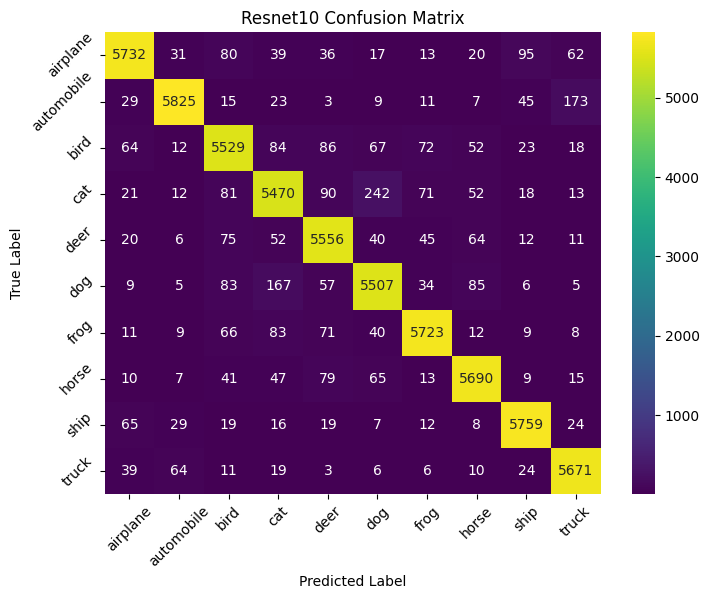

time: 623 ms (started: 2023-12-13 21:56:19 +00:00)


In [ ]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


time: 741 µs (started: 2023-12-13 19:11:29 +00:00)


In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


time: 702 µs (started: 2023-12-13 19:11:32 +00:00)


In [ ]:
model_wd = NetWidth(n_chans1=32).to(device=device)
optimizer_wd = optim.SGD(model_wd.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop_l2reg(
    n_epochs = 200,
    optimizer = optimizer_wd,
    model = model_wd,
    loss_fn = loss_fn,
    train_loader = training_loader,
)

2023-12-13 19:12:16.597921 Epoch 1, Training loss 1.8576094001359995
2023-12-13 19:12:26.383090 Epoch 2, Training loss 1.531466497493263
2023-12-13 19:12:45.671417 Epoch 4, Training loss 1.2795376291811962
2023-12-13 19:13:04.704908 Epoch 6, Training loss 1.1589877257267787
2023-12-13 19:13:23.969075 Epoch 8, Training loss 1.079612054316874
2023-12-13 19:13:43.266782 Epoch 10, Training loss 1.0263506383828758
2023-12-13 19:14:02.442789 Epoch 12, Training loss 0.9875847957527798
2023-12-13 19:14:21.816484 Epoch 14, Training loss 0.9583458065872229
2023-12-13 19:14:40.871186 Epoch 16, Training loss 0.9348329424629285
2023-12-13 19:15:00.121709 Epoch 18, Training loss 0.9156976096994665
2023-12-13 19:15:19.160405 Epoch 20, Training loss 0.9010320767827013
2023-12-13 19:15:38.528500 Epoch 22, Training loss 0.8908711840575578
2023-12-13 19:15:57.872082 Epoch 24, Training loss 0.8799918429903395
2023-12-13 19:16:17.064179 Epoch 26, Training loss 0.8704047523586703
2023-12-13 19:16:36.620407 

In [ ]:

accuracy_weight_delay, predictions_weight_delay, expected_labels_weight_delay = validate(model_wd, train_loader, val_loader)


Accuracy train: 0.85
Accuracy val: 0.68
time: 14.2 s (started: 2023-12-13 21:58:19 +00:00)


In [ ]:
print(classification_report(predictions_weight_delay, expected_labels_weight_delay, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      5997
  automobile       0.91      0.92      0.91      5941
        bird       0.70      0.79      0.74      5296
         cat       0.69      0.74      0.72      5625
        deer       0.73      0.84      0.78      5180
         dog       0.79      0.71      0.75      6620
        frog       0.92      0.76      0.83      7229
       horse       0.86      0.85      0.86      6122
        ship       0.89      0.90      0.89      5913
       truck       0.89      0.88      0.89      6077

    accuracy                           0.82     60000
   macro avg       0.82      0.82      0.82     60000
weighted avg       0.83      0.82      0.82     60000

time: 133 ms (started: 2023-12-13 21:59:16 +00:00)


In [ ]:
precision_weight_delay = precision_score(predictions_weight_delay, expected_labels_weight_delay, average='macro')
recall_weight_delay = recall_score(predictions_weight_delay, expected_labels_weight_delay, average='macro')
cnf_matrix_weight_delay = confusion_matrix(predictions_weight_delay, expected_labels_weight_delay)


time: 151 ms (started: 2023-12-13 21:59:44 +00:00)


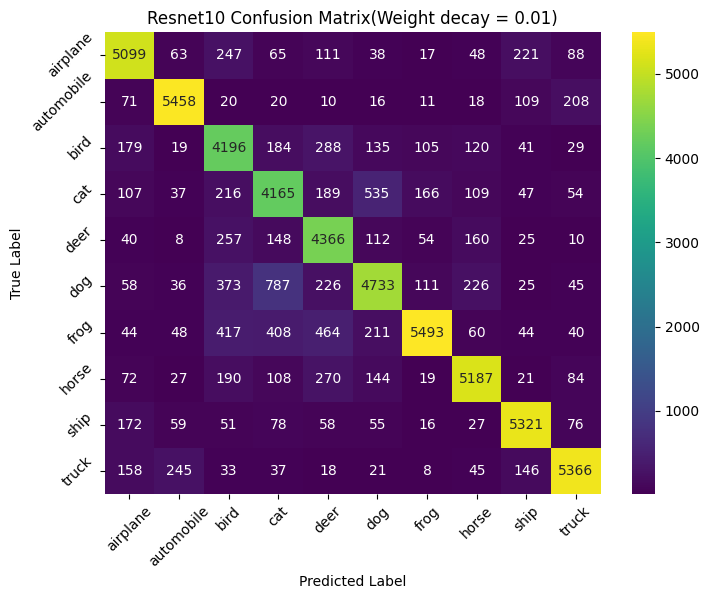

time: 414 ms (started: 2023-12-13 22:00:05 +00:00)


In [ ]:

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_weight_delay, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix(Weight decay = 0.01)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 917 µs (started: 2023-12-13 22:00:10 +00:00)


In [ ]:
model_dropout = NetDropout(n_chans1=32).to(device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer_dropout,
    model = model_dropout,
    loss_function = loss_function,
    training_loader = training_loader,
)


2023-12-13 22:04:56.947411 Epoch 1, Training loss 1.8808026897243713
2023-12-13 22:05:05.432516 Epoch 2, Training loss 1.5950897834427602
2023-12-13 22:05:21.705149 Epoch 4, Training loss 1.4219086202611086
2023-12-13 22:05:37.979507 Epoch 6, Training loss 1.3091389057122205
2023-12-13 22:05:54.328487 Epoch 8, Training loss 1.23515831234359
2023-12-13 22:06:10.597164 Epoch 10, Training loss 1.1931401022870192
2023-12-13 22:06:27.155845 Epoch 12, Training loss 1.1547643602924018
2023-12-13 22:06:43.262173 Epoch 14, Training loss 1.1280126914868198
2023-12-13 22:06:59.884261 Epoch 16, Training loss 1.1088263403698182
2023-12-13 22:07:16.409814 Epoch 18, Training loss 1.0919536352157593
2023-12-13 22:07:32.787130 Epoch 20, Training loss 1.0786767097062508
2023-12-13 22:07:48.862712 Epoch 22, Training loss 1.0645093995832284
2023-12-13 22:08:05.239936 Epoch 24, Training loss 1.0534052623820778
2023-12-13 22:08:21.659725 Epoch 26, Training loss 1.0399450173914928
2023-12-13 22:08:38.489578 

In [ ]:
accuracy_dropout, predictions_dropout, expected_labels_dropout = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.70
Accuracy val: 0.62
time: 14.7 s (started: 2023-12-13 22:51:51 +00:00)


In [ ]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))


              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      5957
  automobile       0.79      0.80      0.80      5901
        bird       0.56      0.61      0.58      5517
         cat       0.50      0.53      0.51      5677
        deer       0.68      0.60      0.64      6815
         dog       0.55      0.60      0.57      5516
        frog       0.72      0.76      0.74      5713
       horse       0.73      0.71      0.72      6174
        ship       0.81      0.75      0.78      6481
       truck       0.78      0.75      0.76      6249

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.69      0.68      0.69     60000

time: 134 ms (started: 2023-12-13 22:52:09 +00:00)


In [ ]:
precision_dropout = precision_score(predictions_dropout, expected_labels_dropout, average='macro')
recall_dropout = recall_score(predictions_dropout, expected_labels_dropout, average='macro')
cnf_matrix_dropout = confusion_matrix(predictions_dropout, expected_labels_dropout)

time: 148 ms (started: 2023-12-13 22:52:12 +00:00)


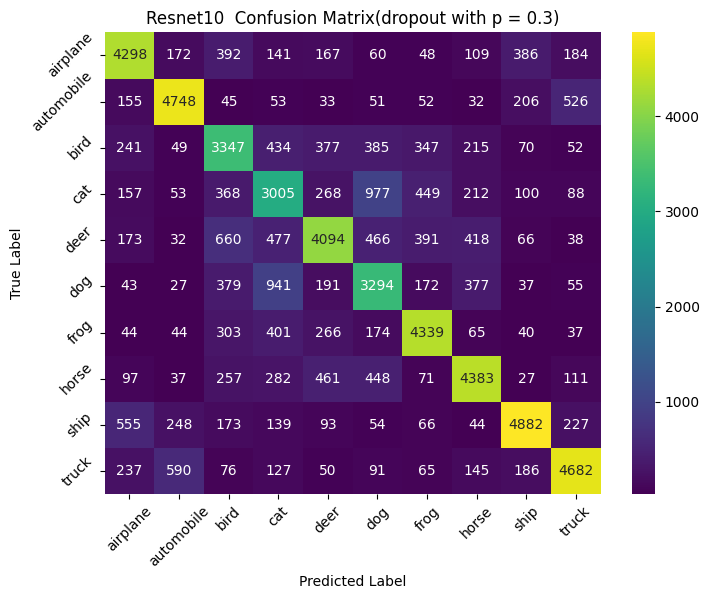

time: 442 ms (started: 2023-12-13 22:52:26 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_dropout, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10  Confusion Matrix(dropout with p = 0.3)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()


In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 851 µs (started: 2023-12-13 22:54:19 +00:00)


In [ ]:
model_batch_normalization = NetBatchNorm(n_chans1=32).to(device=device)
optimizer_batch_normalization = optim.SGD(model_batch_normalization.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 300,
    optimizer = optimizer_batch_normalization,
    model = model_batch_normalization,
    loss_function = loss_function,
    training_loader = training_loader,
)

2023-12-13 22:55:01.801026 Epoch 1, Training loss 1.6383422809156636
2023-12-13 22:55:10.242617 Epoch 2, Training loss 1.3263099405220968
2023-12-13 22:55:26.720229 Epoch 4, Training loss 1.1090577126540822
2023-12-13 22:55:43.708863 Epoch 6, Training loss 0.9936946867676172
2023-12-13 22:56:00.908850 Epoch 8, Training loss 0.9145582134305706
2023-12-13 22:56:17.849988 Epoch 10, Training loss 0.8621789917912304
2023-12-13 22:56:34.844534 Epoch 12, Training loss 0.817458958444272
2023-12-13 22:56:51.932760 Epoch 14, Training loss 0.780129258707404
2023-12-13 22:57:08.664715 Epoch 16, Training loss 0.7494612212220751
2023-12-13 22:57:25.454321 Epoch 18, Training loss 0.7232210124560983
2023-12-13 22:57:42.515407 Epoch 20, Training loss 0.6997992618299034
2023-12-13 22:57:59.780116 Epoch 22, Training loss 0.6761796925019089
2023-12-13 22:58:16.780148 Epoch 24, Training loss 0.6558429590227965
2023-12-13 22:58:34.045011 Epoch 26, Training loss 0.6350534486412163
2023-12-13 22:58:51.105819 

In [ ]:
accuracy_batch_normalization, predictions_batch_normalization, expected_labels_batch_normalization = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.69
Accuracy val: 0.61
time: 14.7 s (started: 2023-12-13 23:39:03 +00:00)


In [ ]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      5957
  automobile       0.79      0.80      0.80      5901
        bird       0.56      0.61      0.58      5517
         cat       0.50      0.53      0.51      5677
        deer       0.68      0.60      0.64      6815
         dog       0.55      0.60      0.57      5516
        frog       0.72      0.76      0.74      5713
       horse       0.73      0.71      0.72      6174
        ship       0.81      0.75      0.78      6481
       truck       0.78      0.75      0.76      6249

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.69      0.68      0.69     60000

time: 134 ms (started: 2023-12-13 23:43:15 +00:00)


In [ ]:
precision_batch_norm = precision_score(predictions_batch_normalization, expected_labels_batch_normalization, average='macro')
recall_batch_norm = recall_score(predictions_batch_normalization, expected_labels_batch_normalization, average='macro')
cnf_matrix_batch_norm = confusion_matrix(predictions_batch_normalization, expected_labels_batch_normalization)

time: 157 ms (started: 2023-12-13 23:43:18 +00:00)


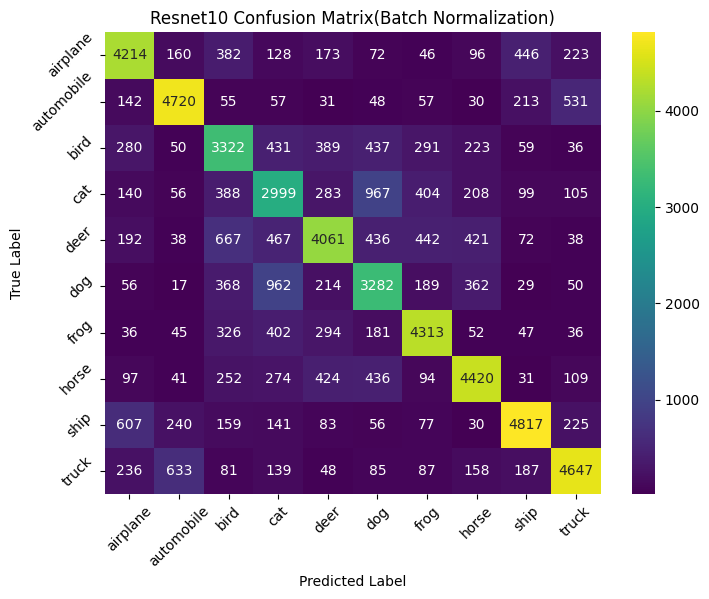

time: 665 ms (started: 2023-12-13 23:43:32 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_batch_norm, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix(Batch Normalization)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()
